### Predict whether a crime incident would result in an arrest 

In [1]:
import pandas as pd
import boto3
import sagemaker

# Define S3 details
s3_bucket = "chicago-crimes-project"  
s3_key = "processed/chicago_crimes_filtered.csv"  
s3_uri = f"s3://{s3_bucket}/{s3_key}"

# Load dataset from S3
df = pd.read_csv(s3_uri)

# Convert 'Date' column back to datetime format
df['Date'] = pd.to_datetime(df['Date'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/26/25 20:16:49] INFO     Found credentials from IAM Role:                                   ]8;id=709195;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=284014;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:286: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


[04/26/25 20:16:58] INFO     Found credentials from IAM Role:                                   ]8;id=543487;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=156863;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [2]:
print(df.isnull().sum())

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
Month                   0
Day                     0
Hour                    0
Weekday                 0
dtype: int64


In [3]:
# Quick overview of the dataset
print(df.info())

# Summary statistics of numerical columns
print(df.describe())

# Check unique values in categorical columns
for col in ['Primary Type', 'Location Description', 'IUCR']:
    print(f"\nUnique values in {col}: {df[col].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509184 entries, 0 to 2509183
Data columns (total 26 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Case Number           object        
 2   Date                  datetime64[ns]
 3   Block                 object        
 4   IUCR                  object        
 5   Primary Type          object        
 6   Description           object        
 7   Location Description  object        
 8   Arrest                bool          
 9   Domestic              bool          
 10  Beat                  int64         
 11  District              float64       
 12  Ward                  float64       
 13  Community Area        float64       
 14  FBI Code              object        
 15  X Coordinate          float64       
 16  Y Coordinate          float64       
 17  Year                  int64         
 18  Updated On            object        
 19  

In [4]:
# Check unique crime types that may have variations
print(df["Primary Type"].value_counts())

THEFT                                565025
BATTERY                              465417
CRIMINAL DAMAGE                      280956
ASSAULT                              203825
DECEPTIVE PRACTICE                   168269
OTHER OFFENSE                        160558
MOTOR VEHICLE THEFT                  146441
NARCOTICS                            102169
BURGLARY                             101388
ROBBERY                               96863
WEAPONS VIOLATION                     66558
CRIMINAL TRESPASS                     55296
OFFENSE INVOLVING CHILDREN            20043
PUBLIC PEACE VIOLATION                12933
SEX OFFENSE                           10952
INTERFERENCE WITH PUBLIC OFFICER       8958
CRIMINAL SEXUAL ASSAULT                8573
HOMICIDE                               6694
CRIM SEXUAL ASSAULT                    6278
PROSTITUTION                           5445
ARSON                                  4746
STALKING                               3008
LIQUOR LAW VIOLATION            

In [5]:
crime_mapping = {
    "NON - CRIMINAL": "NON-CRIMINAL",
    "NON-CRIMINAL (SUBJECT SPECIFIED)": "NON-CRIMINAL",
    "CRIM SEXUAL ASSAULT": "CRIMINAL SEXUAL ASSAULT",
    "OTHER NARCOTIC VIOLATION": "NARCOTICS",
}

# Apply renaming
df["Primary Type"] = df["Primary Type"].replace(crime_mapping)

# Check new unique crime types
print(df["Primary Type"].value_counts())

THEFT                                565025
BATTERY                              465417
CRIMINAL DAMAGE                      280956
ASSAULT                              203825
DECEPTIVE PRACTICE                   168269
OTHER OFFENSE                        160558
MOTOR VEHICLE THEFT                  146441
NARCOTICS                            102221
BURGLARY                             101388
ROBBERY                               96863
WEAPONS VIOLATION                     66558
CRIMINAL TRESPASS                     55296
OFFENSE INVOLVING CHILDREN            20043
CRIMINAL SEXUAL ASSAULT               14851
PUBLIC PEACE VIOLATION                12933
SEX OFFENSE                           10952
INTERFERENCE WITH PUBLIC OFFICER       8958
HOMICIDE                               6694
PROSTITUTION                           5445
ARSON                                  4746
STALKING                               3008
LIQUOR LAW VIOLATION                   2140
INTIMIDATION                    

In [6]:
# Keep only reasonable latitude/longitude values for Chicago
df = df[(df['Latitude'] > 41) & (df['Latitude'] < 42.5)]
df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87)]

# Reset index
df.reset_index(drop=True, inplace=True)

[04/26/25 20:18:02] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=928451;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=985483;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

[04/26/25 20:18:05] INFO     generated new fontManager                                         ]8;id=944977;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=504944;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

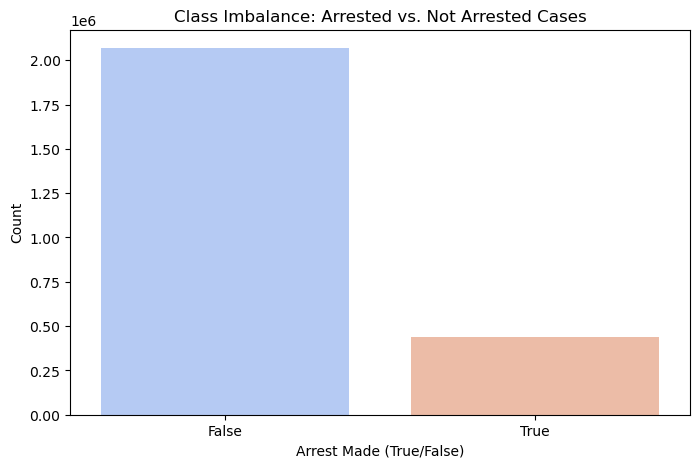

In [7]:
#Class Imbalance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.barplot(x=df["Arrest"].value_counts().index, y=df["Arrest"].value_counts().values, palette="coolwarm", hue = df["Arrest"].value_counts().index, legend = False)
plt.xlabel("Arrest Made (True/False)")
plt.ylabel("Count")
plt.title("Class Imbalance: Arrested vs. Not Arrested Cases")
plt.show()

### Main Modelling Framework 

Top correlated features with 'Arrest':
 Arrest                  1.000000
FBI Code                0.291388
Description             0.141066
Hour                    0.062685
Location Description    0.037347
Primary Type            0.036404
Community Area          0.020536
Weekday                 0.004417
Day                    -0.000712
Ward                   -0.010165
Domestic               -0.019318
Beat                   -0.023549
District               -0.023631
Latitude               -0.023764
Y Coordinate           -0.023947
Month                  -0.032221
X Coordinate           -0.033215
Longitude              -0.033851
Year                   -0.104497
ID                     -0.107949
Name: Arrest, dtype: float64


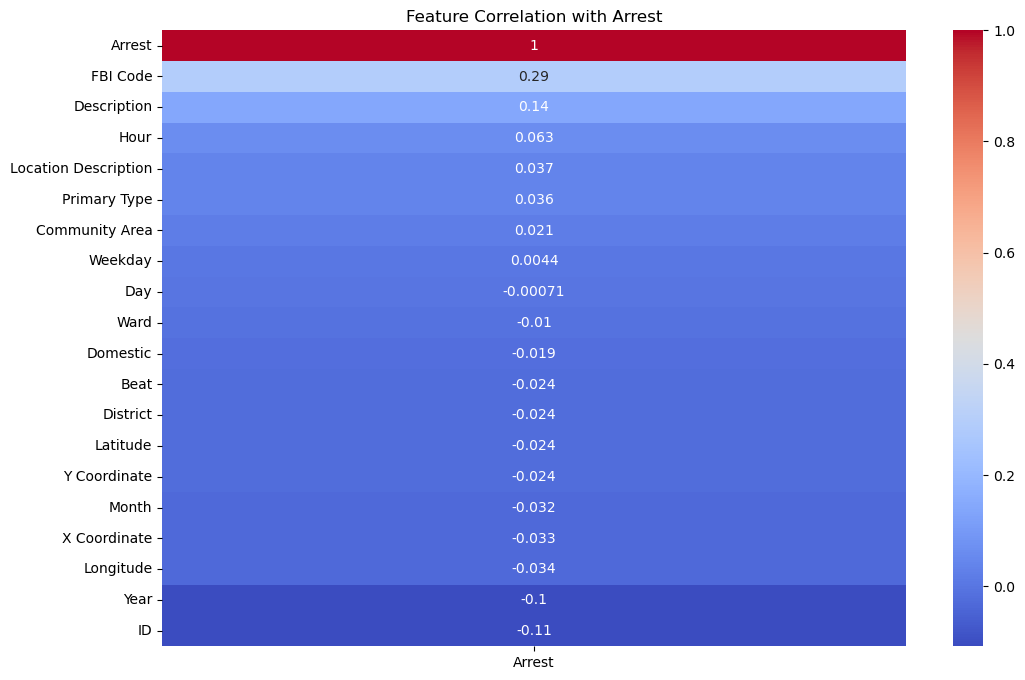

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 1: Encode categorical columns for correlation check
encoded_df = df.copy()
categorical_cols = ['Primary Type', 'Location Description', 'FBI Code', 'Description']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    label_encoders[col] = le  # Saving encoders for later use

# Step 2: Correlation matrix with 'Arrest'
correlation_matrix = encoded_df.corr(numeric_only=True)
arrest_corr = correlation_matrix['Arrest'].sort_values(ascending=False)
print("Top correlated features with 'Arrest':\n", arrest_corr)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['Arrest']].sort_values(by='Arrest', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Arrest")
plt.show()

In [9]:
# Downsample majority class to match minority class
df_majority = df[df['Arrest'] == 0]
df_minority = df[df['Arrest'] == 1]

print("Before downsampling:")
print("Non-arrests:", len(df_majority))
print("Arrests:", len(df_minority))

# Downsample
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nAfter downsampling:")
print(df_downsampled['Arrest'].value_counts())

Before downsampling:
Non-arrests: 2068548
Arrests: 440632

After downsampling:
True     440632
False    440632
Name: Arrest, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Select features and target
selected_features = ['FBI Code', 'Description', 'Primary Type',
                     'Location Description', 'Hour', 'Community Area', 'Weekday']

X = df_downsampled[selected_features].copy()
y = df_downsampled['Arrest']

# Label encode categorical columns
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split into train/test before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Scale features after splitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build final train and test DataFrames
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
train_df['Arrest'] = y_train.reset_index(drop=True)

test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
test_df['Arrest'] = y_test.reset_index(drop=True)

# Save train and test files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [11]:
#train_df.shape
# Check for NaNs in training data
print("Training Data:")
print(train_df.isnull().sum())
print("Total NaNs in training data:", train_df.isnull().sum().sum())

# Check for NaNs in testing data
print("\nTesting Data:")
print(test_df.isnull().sum())
print("Total NaNs in testing data:", test_df.isnull().sum().sum())


Training Data:
FBI Code                0
Description             0
Primary Type            0
Location Description    0
Hour                    0
Community Area          0
Weekday                 0
Arrest                  0
dtype: int64
Total NaNs in training data: 0

Testing Data:
FBI Code                0
Description             0
Primary Type            0
Location Description    0
Hour                    0
Community Area          0
Weekday                 0
Arrest                  0
dtype: int64
Total NaNs in testing data: 0


### Random Forest Model Variations - Sagemaker

In [12]:
from sagemaker import get_execution_role
import sagemaker

# Initialize
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'crime-arrest-model'

# Upload the data
train_path = sagemaker_session.upload_data('train.csv', bucket=bucket, key_prefix=f'{prefix}/train')
test_path = sagemaker_session.upload_data('test.csv', bucket=bucket, key_prefix=f'{prefix}/test')

[04/26/25 20:18:44] INFO     Found credentials from IAM Role:                                   ]8;id=438628;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=119939;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=35690;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=127227;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [74]:
# RF Model
from sagemaker.sklearn.estimator import SKLearn

rf_estimator = SKLearn(
    entry_point="rf_script.py",
    role=role,
    instance_type="ml.m5.large",
    framework_version="1.2-1",
    py_version="py3",
    hyperparameters={
        "n_estimators": 100
    },
    sagemaker_session=sagemaker_session,
    output_path=f"s3://{bucket}/rf/output"
)

rf_estimator.fit({"train": train_path, "validation": test_path})

[04/25/25 23:01:19] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=420721;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=849040;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=973172;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=909960;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-scikit-learn-2025-04-25-23-01-19-376                                        

2025-04-25 23:01:21 Starting - Starting the training job...
2025-04-25 23:01:36 Starting - Preparing the instances for training...
2025-04-25 23:02:00 Downloading - Downloading input data...
2025-04-25 23:02:30 Downloading - Downloading the training image.....2025-04-25 23:03:32,008 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-04-25 23:03:32,011 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-25 23:03:32,014 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-25 23:03:32,032 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-04-25 23:03:32,249 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-25 23:03:32,253 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-25 23:03:32,271 sagemaker-training-toolkit INFO     No GPUs detected (normal if n

In [75]:
#RF with hyperparameter tuning 
rf_estimator_2 = SKLearn(
    entry_point="rf_script.py",
    role=role,
    instance_type="ml.m5.large",
    framework_version="1.2-1",
    py_version="py3",
    hyperparameters={
        "n_estimators": 100,
        "max_depth": 15,
        "min_samples_split": 5,
        "min_samples_leaf": 2
    },
    sagemaker_session=sagemaker_session,
    output_path=f"s3://{bucket}/rf/output"
)

rf_estimator_2.fit({"train": train_path, "validation": test_path})

[04/25/25 23:06:38] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=773132;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=693321;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[04/25/25 23:06:39] INFO     Creating training-job with name:                                       ]8;id=813291;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=620996;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-scikit-learn-2025-04-25-23-06-38-919                                        

2025-04-25 23:06:40 Starting - Starting the training job...
2025-04-25 23:06:55 Starting - Preparing the instances for training...
2025-04-25 23:07:15 Downloading - Downloading input data...
2025-04-25 23:07:45 Downloading - Downloading the training image....2025-04-25 23:08:47,634 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-04-25 23:08:47,637 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-25 23:08:47,640 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-25 23:08:47,657 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-04-25 23:08:47,934 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-25 23:08:47,937 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-25 23:08:47,955 sagemaker-training-toolkit INFO     No GPUs detected (normal if no

In [76]:
#RF with PCA
rf_estimator_pca = SKLearn(
    entry_point="rf_script.py",
    role=role,
    instance_type="ml.m5.large",
    framework_version="1.2-1",
    py_version="py3",
    hyperparameters={
        "n_estimators": 100, # Consider the max params which produced the best results and add PCA to that
        "max_depth": 15,
        "min_samples_split": 5,
        "min_samples_leaf": 2,
        "pca_variance": 0.95
    },
    sagemaker_session=sagemaker_session,
    output_path=f"s3://{bucket}/rf/output"
)

rf_estimator_pca.fit({"train": train_path, "validation": test_path})

[04/25/25 23:10:27] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=407698;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=740975;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=372283;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=581322;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-scikit-learn-2025-04-25-23-10-27-453                                        

2025-04-25 23:10:29 Starting - Starting the training job...
2025-04-25 23:10:43 Starting - Preparing the instances for training...
2025-04-25 23:11:07 Downloading - Downloading input data...
2025-04-25 23:11:37 Downloading - Downloading the training image...
2025-04-25 23:12:33 Training - Training image download completed. Training in progress...2025-04-25 23:12:37,695 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-04-25 23:12:37,698 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-25 23:12:37,701 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-25 23:12:37,718 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-04-25 23:12:37,985 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-25 23:12:37,988 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2

### XGBoost Classifier Variations - Sagemaker

In [43]:
# XGBoost Estimator for classification
from sagemaker.xgboost.estimator import XGBoost
xgb = XGBoost(
    entry_point='xgb_script_initial.py',
    framework_version='1.7-1',
    hyperparameters={
        'max_depth': 5, # Initial set-up as shown in lecture
        'eta': 0.2,
        'gamma': 4,
        'min_child_weight': 6,
        'subsample': 0.8,
        'verbosity': 1,
        'num_round': 50
    },
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Train the model
xgb.fit({
    'train': train_path,
    'validation': test_path
})

[04/25/25 20:34:37] INFO     Found credentials from IAM Role:                                   ]8;id=238820;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=639384;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Ignoring unnecessary Python version: py3.                            ]8;id=21921;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=518769;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=475611;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=276378;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=750552;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=529122;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=375303;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=359428;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-25-20-34-37-656                                             

2025-04-25 20:34:38 Starting - Starting the training job...
2025-04-25 20:35:02 Starting - Preparing the instances for training...
2025-04-25 20:35:41 Downloading - Downloading input data......
2025-04-25 20:36:14 Downloading - Downloading the training image...
2025-04-25 20:37:00 Training - Training image download completed. Training in progress../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-04-25 20:37:05.224 ip-10-2-80-112.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-25 20:37:05.245 ip-10-2-80-112.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-25:20:37:05:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-25:20:37:05:INFO] No GPUs detected (normal if no gpus installed)
[2025-

In [44]:
# XGBoost Estimator for classification
xgb_2 = XGBoost(
    entry_point='xgb_script_initial.py',
    framework_version='1.7-1',
    hyperparameters={
        'max_depth': 6,
        'eta': 0.5,
        'gamma': 0,
        'min_child_weight': 6,
        'subsample': 1,
        'verbosity': 1,
    },
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Train the model
xgb_2.fit({
    'train': train_path,
    'validation': test_path
})

[04/25/25 20:39:01] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=567988;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=726967;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=988437;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=196832;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=20677;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=887920;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=655695;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=103420;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-25-20-39-01-463                                             

2025-04-25 20:39:03 Starting - Starting the training job...
2025-04-25 20:39:18 Starting - Preparing the instances for training...
2025-04-25 20:39:41 Downloading - Downloading input data...
2025-04-25 20:40:36 Downloading - Downloading the training image......
2025-04-25 20:41:32 Training - Training image download completed. Training in progress...[2025-04-25 20:41:36.882 ip-10-2-68-105.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-25 20:41:36.913 ip-10-2-68-105.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-25:20:41:37:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-25:20:41:37:INFO] No GPUs detected (normal if no gpus installed)
[2025-04-25:20:41:37:INFO] Invoking user training script.
[2025-04-25:20:41:37:INFO] Module script does not provide a setup.py. 
Generating setup.py
[2025-04-25:20:41:37:INFO] Generating setup.cfg
[2025-04-25:20:41:37:INFO] Generating MANIFEST.in
[2025-04-25:20:41

In [77]:
# XGBoost Estimator for classification
xgb_3 = XGBoost(
    entry_point='xgb_script.py',
    framework_version='1.7-1',
    hyperparameters={
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,                           # smaller learning rate
    "max_depth": 10,                        # deeper trees
    "min_child_weight": 5,                
    "gamma": 1,                            # regularization
    "subsample": 0.8,                      # use 80% of rows
    "colsample_bytree": 0.8,               # use 80% of features
    "verbosity": 1,
    "num_round": 500, 
    "apply_pca": 0

    },
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Train the model
xgb_3.fit({
    'train': train_path,
    'validation': test_path
})

[04/25/25 23:20:23] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=94896;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=843625;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=311359;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=536826;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=159566;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=746193;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=531735;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=945107;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-25-23-20-23-800                                             

2025-04-25 23:20:25 Starting - Starting the training job...
2025-04-25 23:20:40 Starting - Preparing the instances for training...
2025-04-25 23:21:03 Downloading - Downloading input data...
2025-04-25 23:21:53 Downloading - Downloading the training image......
2025-04-25 23:22:46 Training - Training image download completed. Training in progress..[2025-04-25 23:22:50.759 ip-10-0-80-102.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-25 23:22:50.788 ip-10-0-80-102.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-25:23:22:51:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-25:23:22:51:INFO] No GPUs detected (normal if no gpus installed)
[2025-04-25:23:22:51:INFO] Invoking user training script.
[2025-04-25:23:22:51:INFO] Module xgb_script does not provide a setup.py. 
Generating setup.py
[2025-04-25:23:22:51:INFO] Generating setup.cfg
[2025-04-25:23:22:51:INFO] Generating MANIFEST.in
[2025-04-25:23

In [79]:
# XGBoost Estimator with PCA
xgb_with_pca = XGBoost(
    entry_point='xgb_script.py',
    framework_version='1.7-1',
    hyperparameters={
    "objective": "binary:logistic",   # Consider the params from the best performing model and applying PCA with 95% variance
    "eval_metric": "auc",
    "eta": 0.05,                           
    "max_depth": 10,                       
    "min_child_weight": 5,                 
    "gamma": 1,                            
    "subsample": 0.8,                      
    "colsample_bytree": 0.8,               
    "verbosity": 1,
    "num_round": 500, 
    "apply_pca": 1,
    "pca_variance": 0.95

    },
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Train the model
xgb_with_pca.fit({
    'train': train_path,
    'validation': test_path
})

[04/25/25 23:33:23] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=723001;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=943947;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=691734;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=730694;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=308182;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=482809;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=259820;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=715422;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-25-23-33-23-654                                             

2025-04-25 23:33:25 Starting - Starting the training job...
2025-04-25 23:33:39 Starting - Preparing the instances for training...
2025-04-25 23:34:02 Downloading - Downloading input data...
2025-04-25 23:34:57 Downloading - Downloading the training image......
2025-04-25 23:35:48 Training - Training image download completed. Training in progress..[2025-04-25 23:35:52.402 ip-10-2-112-127.ec2.internal:8 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-25 23:35:52.437 ip-10-2-112-127.ec2.internal:8 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-25:23:35:52:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-25:23:35:52:INFO] No GPUs detected (normal if no gpus installed)
[2025-04-25:23:35:52:INFO] Invoking user training script.
[2025-04-25:23:35:53:INFO] Module xgb_script does not provide a setup.py. 
Generating setup.py
[2025-04-25:23:35:53:INFO] Generating setup.cfg
[2025-04-25:23:35:53:INFO] Generating MANIFEST.in
[2025-04-25:

In [16]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.3 MB/s eta 0:00:00


In [15]:
#visualizing confusion matrix and ROC-AUC Curve for best performing XGBoost Model
import tarfile
import xgboost as xgb

s3 = boto3.client('s3')
bucket = 'sagemaker-us-east-1-377009968774'
key = 'crime-arrest-model/output/sagemaker-xgboost-2025-04-25-23-20-23-800/output/model.tar.gz'  # find in SageMaker console
local_model_path = 'model.tar.gz'

# Download model artifact
s3.download_file(bucket, key, local_model_path)

#unzip the model output
with tarfile.open(local_model_path) as tar:
    tar.extractall()

booster = xgb.Booster()
booster.load_model('xgboost-model')

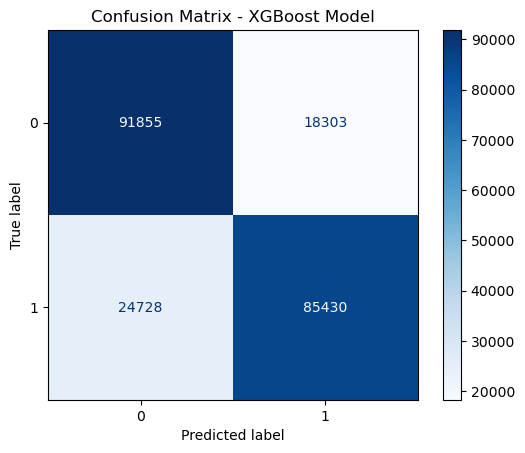

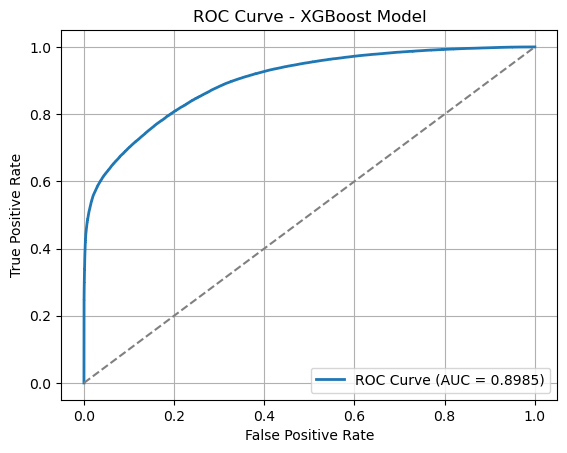

✅ RMSE (Root Mean Squared Error): 0.3575
✅ ROC-AUC Score: 0.8985


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb

# Load test set
X_test = pd.read_csv('test.csv').drop('Arrest', axis=1)  # features
y_test = pd.read_csv('test.csv')['Arrest']               # true labels

# Convert to DMatrix for XGBoost
dtest = xgb.DMatrix(X_test)

# Predict using loaded booster
y_pred_proba = booster.predict(dtest)         # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)      # Class predictions

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGBoost Model')
plt.grid(False)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Model')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# RMSE Calculation
rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
print(f"✅ RMSE (Root Mean Squared Error): {rmse:.4f}")

# ROC-AUC Score Printout
print(f"✅ ROC-AUC Score: {roc_auc:.4f}")

### MLP Model Variations - Sagemaker

In [14]:
# MLP Model
from sagemaker.sklearn.estimator import SKLearn
mlp_estimator = SKLearn(
    entry_point="mlp_script.py",
    role=role,
    instance_type="ml.m5.large",
    framework_version="1.2-1",
    py_version="py3",
    hyperparameters={
        "hidden_layer_sizes": 100, #base parameters
        "max_iter": 300,
        "pca_variance":0
    },
    sagemaker_session=sagemaker_session,
    output_path=f"s3://{bucket}/mlp/output"
)

mlp_estimator.fit({
    "train": train_path,
    "validation": test_path
})

[04/26/25 15:13:17] INFO     Found credentials from IAM Role:                                   ]8;id=819603;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=456357;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=984701;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=408861;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[04/26/25 15:13:18] INFO     Creating training-job with name:                                       ]8;id=962937;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=405611;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-scikit-learn-2025-04-26-15-13-17-919                                        

2025-04-26 15:13:19 Starting - Starting the training job...
2025-04-26 15:13:53 Downloading - Downloading input data......
2025-04-26 15:14:24 Downloading - Downloading the training image......
2025-04-26 15:15:25 Training - Training image download completed. Training in progress.....2025-04-26 15:15:27,351 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-04-26 15:15:27,355 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-26 15:15:27,358 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-26 15:15:27,375 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-04-26 15:15:27,614 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-26 15:15:27,617 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-26 15:15:27,636 sagemaker-training-toolkit INFO     No G

In [18]:
#MLP with PCA
from sagemaker.sklearn.estimator import SKLearn
mlp_estimator_with_pca = SKLearn(
    entry_point="mlp_script.py",
    role=role,
    instance_type="ml.m5.large",
    framework_version="0.23-1",
    py_version="py3",
    hyperparameters={
        "hidden_layer_sizes": 100,
        "max_iter": 300,
        "pca_variance":0.95 #setting 95% variance 
    },
    sagemaker_session=sagemaker_session,
    output_path=f"s3://{bucket}/mlp/output"
)

mlp_estimator_with_pca.fit({
    "train": train_path,
    "validation": test_path
})

[04/26/25 21:15:38] INFO     Found credentials from IAM Role:                                   ]8;id=386389;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=258901;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=151095;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=665697;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[04/26/25 21:15:39] INFO     Creating training-job with name:                                       ]8;id=916852;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=98789;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-scikit-learn-2025-04-26-21-15-38-999                                        

2025-04-26 21:15:40 Starting - Starting the training job...
2025-04-26 21:15:54 Starting - Preparing the instances for training...
2025-04-26 21:16:16 Downloading - Downloading input data...
2025-04-26 21:16:46 Downloading - Downloading the training image...
2025-04-26 21:17:27 Training - Training image download completed. Training in progress...2025-04-26 21:17:31,808 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-04-26 21:17:31,811 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-26 21:17:31,857 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-04-26 21:17:32,094 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-26 21:17:32,107 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-26 21:17:32,119 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-26 21

In [ ]:
#predictor.delete_endpoint()

### Using Python built-in library models to finalize Sagemaker Models

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Predict probabilities for ROC-AUC
y_scores = logreg.predict_proba(X_test)[:, 1]

# Print metrics
print("\n Logistic Regression:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_scores))


 Logistic Regression:
              precision    recall  f1-score   support

       False     0.6384    0.7611    0.6943    110158
        True     0.7042    0.5688    0.6293    110158

    accuracy                         0.6650    220316
   macro avg     0.6713    0.6650    0.6618    220316
weighted avg     0.6713    0.6650    0.6618    220316

Confusion Matrix:
 [[83843 26315]
 [47500 62658]]
ROC-AUC Score: 0.6975566255283501


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1]

print("\n Random Forest (Downsampled):")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_scores))


 Random Forest (Downsampled):
              precision    recall  f1-score   support

       False     0.7693    0.7996    0.7842    110158
        True     0.7914    0.7603    0.7755    110158

    accuracy                         0.7799    220316
   macro avg     0.7804    0.7799    0.7798    220316
weighted avg     0.7804    0.7799    0.7798    220316

Confusion Matrix:
 [[88082 22076]
 [26410 83748]]
ROC-AUC Score: 0.8692436841932323


In [83]:
rf = RandomForestClassifier(n_estimators=300, max_depth = 15, min_samples_split = 5, min_samples_leaf=2, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1]

print("\n Random Forest (Downsampled):")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_scores))


 Random Forest (Downsampled):
              precision    recall  f1-score   support

       False     0.7833    0.8305    0.8062    110158
        True     0.8196    0.7702    0.7941    110158

    accuracy                         0.8004    220316
   macro avg     0.8015    0.8004    0.8002    220316
weighted avg     0.8015    0.8004    0.8002    220316

Confusion Matrix:
 [[91490 18668]
 [25317 84841]]
ROC-AUC Score: 0.8948852356853351


In [19]:
# Normal XGBoost
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
y_scores = xgb.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, digits=4)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_scores)

print("\n XGBoost Classifier (Downsampled):")
print(report)
print(conf_matrix) 
print(roc_auc)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(



 XGBoost Classifier (Downsampled):
              precision    recall  f1-score   support

       False     0.7848    0.8293    0.8064    110158
        True     0.8190    0.7726    0.7951    110158

    accuracy                         0.8009    220316
   macro avg     0.8019    0.8009    0.8008    220316
weighted avg     0.8019    0.8009    0.8008    220316

[[91356 18802]
 [25054 85104]]
0.8954710036261011


In [82]:
# XGBoost with hyperparameter tuning
xgb = XGBClassifier(eval_metric='auc', max_depth=10, learning_rate=0.05, n_estimators=500,min_child_weight=5,
                        subsample=0.8,colsample_bytree=0.8, random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
y_scores = xgb.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, digits=4)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_scores)

print("\n XGBoost Classifier (Downsampled):")
print(report)
print(conf_matrix) 
print(roc_auc)


 XGBoost Classifier (Downsampled):
              precision    recall  f1-score   support

       False     0.7868    0.8302    0.8079    110158
        True     0.8203    0.7750    0.7970    110158

    accuracy                         0.8026    220316
   macro avg     0.8035    0.8026    0.8025    220316
weighted avg     0.8035    0.8026    0.8025    220316

[[91453 18705]
 [24785 85373]]
0.8969161073549288


In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_scores = mlp.predict_proba(X_test)[:, 1]

print("\n MLP Classifier (Downsampled):")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_scores))


 MLP Classifier (Downsampled):
              precision    recall  f1-score   support

       False     0.7728    0.7732    0.7730    110158
        True     0.7731    0.7727    0.7729    110158

    accuracy                         0.7729    220316
   macro avg     0.7729    0.7729    0.7729    220316
weighted avg     0.7729    0.7729    0.7729    220316

Confusion Matrix:
 [[85177 24981]
 [25043 85115]]
ROC-AUC Score: 0.8670436374615266


In [20]:
import xgboost
print("xgboost version:", xgboost.__version__)

xgboost version: 3.0.0
